In [1]:
'''

This code is part of the SIPN2 project focused on improving sub-seasonal to seasonal predictions of Arctic Sea Ice. 
If you use this code for a publication or presentation, please cite the reference in the README.md on the
main page (https://github.com/NicWayand/ESIO). 

Questions or comments should be addressed to nicway@uw.edu

Copyright (c) 2018 Nic Wayand

GNU General Public License v3.0


'''

%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import numpy.ma as ma
import struct
import os
import xarray as xr
import glob
import datetime 
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
import pandas as pd
import itertools
import calendar

# ESIO Imports

from esio import EsioData as ed
from esio import ice_plot
from esio import metrics

import dask
dask.set_options(get=dask.threaded.get)
# from dask.distributed import Client, progress
# client = Client(processes=12)

# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

plt.rcParams.update({'figure.max_open_warning': 0})

#############################################################
# Load in Data
#############################################################
E = ed.EsioData.load()
data_dir = E.data_dir
grid_dir = E.grid_dir
fig_dir = os.path.join(E.fig_dir, 'metrics', 'extent')

In [2]:
out_dir = '/home/disk/sipn/nicway/data/Director_data/RPackage/SIPN'

In [3]:
mod_adj_f = 'Mod_adj_test.nc'
ds_mod_adj = xr.open_dataset(os.path.join(out_dir,mod_adj_f))
ds_mod_adj

<xarray.Dataset>
Dimensions:  (lat: 448, lon: 304, year: 2)
Coordinates:
  * year     (year) int32 29 30
  * lon      (lon) int32 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * lat      (lat) int32 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
Data variables:
    iceInd   (lat, lon, year) float32 ...

In [4]:
mod_f = 'Mod_test.nc'
ds_mod = xr.open_dataset(os.path.join(out_dir,mod_f))
ds_mod

<xarray.Dataset>
Dimensions:  (lat: 448, lon: 304, months: 43, years: 31)
Coordinates:
  * years    (years) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * months   (months) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * lon      (lon) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * lat      (lat) int64 448 447 446 445 444 443 442 441 440 439 438 437 436 ...
Data variables:
    iceInd   (lat, lon, months, years) float64 ...

In [5]:
obs_f = 'Obs_test.nc'
ds_obs = xr.open_dataset(os.path.join(out_dir,obs_f))
ds_obs

<xarray.Dataset>
Dimensions:  (lat: 448, lon: 304, months: 43, years: 31)
Coordinates:
  * lon      (lon) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * lat      (lat) int64 448 447 446 445 444 443 442 441 440 439 438 437 436 ...
  * months   (months) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * years    (years) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
Data variables:
    conc     (lat, lon, months, years) float64 ...

In [6]:
cmonth = 10
cpyear = 29

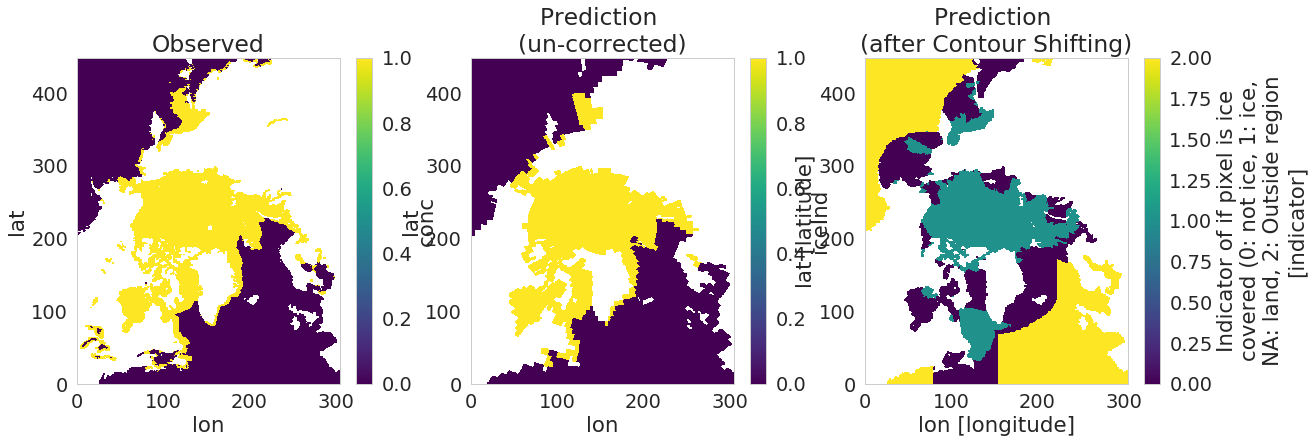

In [7]:
# Compare obs, model, adjusted model
f = plt.figure(figsize=((20,6)))

plt.subplot(1,3,1)
c_O = ds_obs.sel(years=cpyear, months=cmonth).conc
c_O = ((c_O>=15) & (c_O<=100)).where(ds_obs.sel(years=29, months=10).conc<=100)
c_O.plot()
plt.title('Observed')

plt.subplot(1,3,2)
c_M = ds_mod.sel(years=cpyear, months=cmonth).iceInd
(c_M>0.15).where(c_M.notnull()).plot()
plt.title('Prediction \n(un-corrected)')

plt.subplot(1,3,3)
c_M_a = ds_mod_adj.sel(year=cpyear)
# c_M_a.where(c_M_a<=1).iceInd.plot()
c_M_a.iceInd.plot()

plt.title('Prediction \n(after Contour Shifting)')
f.savefig('CS_test.png')

In [9]:
# Check that obs model fore "mapped" days prior, actually predict the bias on target day?

# Something is making bad artifacts....